In [38]:
import os
import re
import hdbscan
import random
import numpy as np
import matplotlib.pyplot as pl

In [128]:
from sklearn import preprocessing
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

In [2]:
def entropy(text): # Функция вычисления энтропии у строки, чем больше одинаковых символов, тем она ниже
    text = str(text)
    prob = [0.0]*256
    l = len(text)
    ent = 0.0
    
    for i in text:
        prob[ord(i)] += 1.0
    for i in prob:
        if i > 0.0:
            ent += (i/l)*np.log(i/l)
    ent = -1.0*ent
    return ent

def mean_entropy(group_list): # Усредненная энтропия для группы id'шников
    group_dist = []
    for i in group_list:
        group_dist.append(entropy(i))
    return np.mean(group_dist)

def success_rate(ip_results):
    n = len(ip_results)
    rate = float(len([res for res in ip_results if res == 'SUCCESS']))/n
    return rate

def id_success_rate(user_ids,treshold=0.5):
    rate = 0.0
    n = len(user_ids.keys())
    
    for id_ in user_ids:
        if float(user_ids[id_][0])/(user_ids[id_][0]+user_ids[id_][1]) >= treshold:
            rate += 1.0
            
    return rate / n 

def avg_time(ip_dates, max_delta_time=86400,treshold=0.8): # Среднее время между запросами в секундах
    n = len(ip_dates)
    if n < 2:
        return max_delta_time
    
    time_deltas = sorted([(ip_dates[i]-ip_dates[i-1]).total_seconds() for i in xrange(1,n)])
    avg_time = np.mean(time_deltas)
    
    for i in xrange(int(n-1.0),int(treshold*n_results)):
        new_avg_time = np.mean(time_deltas[:i])
        if np.abs(new_avg_time - avg_time) > time_eps:
            avg_time = new_avg_time
    
    return avg_time

def avg_hours(ip_dates, treshold=3):
    n = len(ip_dates)
    if n < 2:
        return 0.0
    
    active_hours = []
    time_pointer = 0
    time_current_pos = 0    
    
    while time_current_pos < n:
        while time_current_pos < n and (ip_dates[time_current_pos] - ip_dates[time_pointer]).days < 1:
            time_current_pos += 1
        
        total_hours = 0.0
        list_of_hours = [t.hour for t in ip_dates[time_pointer:time_current_pos]]
        for hour in set(list_of_hours):
            if list_of_hours.count(hour) > treshold:
                total_hours += 1.0
        
        active_hours.append(total_hours)
        time_pointer = time_current_pos
                         
    avg_hours = np.mean(active_hours)
    return avg_hours
    

### Парсим логи, собираем данные

In [4]:
data_file = "collection.dat"
record_re = re.compile(r"^(?:\s*AUTH)\s(\w+)\s(\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2})\s(\d+)\s(\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3})$")
# AUTH FAILED 2017-06-07 21:00:43 41.6.25.31

auth_data = []
with open(data_file,"r") as f:
    for line in f:
        try:
            res = re.findall(record_re,line)[0]
        except:
            print "Ошибка в строке: %s"%(line)
            continue
        
        result, date, user_id,ip_addr = res
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        auth_data.append((result,date,user_id,ip_addr))

auth_data = tuple(auth_data)

distinct_ips = set([rec[-1] for rec in auth_data])
print "Всего в наборе %d различных ip адресов"%(len(distinct_ips))

Ошибка в строке: AUTH FAILED 2017-
Всего в наборе 22995 различных ip адресов


### Сделаем все данные о конкретном ip доступными по словарю

In [5]:
ip_records = dict()
for ip in distinct_ips:
    ip_records[ip] = []
    
for rec in auth_data:
    ip_records[rec[-1]].append(rec[:-1])
    

### На основе полученных данных вычислим следующие признаки:<br>
1) Среднюю энтропию для группы id'шников<br>
2) Рейт $successes/(successes+fails)$ <br>
3) Логарифм общего числа попыток <br>
4) Рейт по $user\_id$ <br>
5) Среднее время между попытками <br>
6) Среднее количество активных часов в сутки <br>


In [95]:
feature_names = ["Усредненная энтропия номеров",
                 "Рейт",
                 "Логарифм общего числа запросов",
                 "Рейт по аккаунтам",
                 "Среднее время между запросами",
                 "Количество активных часов"]

feature_names_e = ["Mean entropy",
                   "Rate",
                   "Log requests",
                   "ID Rate",
                   "Average delta time",
                   "Active hours"]

In [92]:
ip_data = []
ip_ids  = dict()

treshold_for_ids = 0.5
time_eps = 1.0
time_percentage = 0.80

for ip in distinct_ips:
    ip_record = ip_records[ip]
    n_results = len(ip_record)
    
    ip_user_ids = set([rec[2] for rec in ip_record])
    ip_dates = sorted([rec[1] for rec in ip_record])
    ip_results = [rec[0] for rec in ip_record]
    
    user_ids = dict()
    for id_ in ip_user_ids:
        user_ids[id_] = [0.0,0.0]
        
    for rec in ip_record:
        if rec[0] == 'SUCCESS':
            user_ids[rec[2]][0] += 1.0
        else:
            user_ids[rec[2]][1] += 1.0
            
    ip_ids[ip] = user_ids  
    
    all_attempts_log = np.log(n_results)
    rec = (ip,
           mean_entropy(ip_user_ids),
           success_rate(ip_results),
           float(all_attempts_log),
           id_success_rate(user_ids),
           avg_time(ip_dates),
           avg_hours(ip_dates))
    
    ip_data.append(rec)  

In [94]:
data_set = np.array(np.array(ip_data)[:,1:],dtype='float') # Костыль

### Стандартизируем данные <br>
Это должно сделать их более независимыми от длительности промежутка времени, в котором мы их рассматриваем

In [96]:
scaler = preprocessing.StandardScaler().fit(data_set)
data_set = scaler.transform(data_set)

### Кластеризуем данные с помошью DBSCAN <br>
В принципе, можно использовать и другие алгоритмы, такие как <b>*OPTICS*</b>, различные расширения <b>*DBSCAN*</b> (<b>*FS-DBSCAN*</b>, <b>*GDBSCAN*</b>). Однако, производительность их реализация на Python довольно средняя; либо же их реализации вообще нет, и придется писать алгоритм самому. Хотя <b>*DBSCAN*</b> плохо обрабатывает кластера с различной плотностью, на практике он может показать приемлемые результаты. Есть еще новый алгоритм <b>*HDBSCAN*</b>, но для данной задачи он не подошел - оставляет много точек нераспределенными. 


In [97]:
for d in np.linspace(0.20,0.45,6):
    for i in xrange(20,30,5):
        db_scan = DBSCAN(min_samples=i,eps=0.40,algorithm='kd_tree').fit(data_set)
        undefined = float(sum([1 for j in xrange(0,len(db_scan.labels_)) if db_scan.labels_[j] == -1]))
        print "Минимальный размер кластера: %d\nЭпсилон: %f\nПолучилось %d кластеров" % (i,d,len(set(db_scan.labels_)))
        print "%f процентов неопределено\n"%(100.0*undefined/len(data_set))

Минимальный размер кластера: 20
Эпсилон: 0.200000
Получилось 8 кластеров
2.522287 процентов неопределено

Минимальный размер кластера: 25
Эпсилон: 0.200000
Получилось 8 кластеров
2.700587 процентов неопределено

Минимальный размер кластера: 20
Эпсилон: 0.250000
Получилось 8 кластеров
2.522287 процентов неопределено

Минимальный размер кластера: 25
Эпсилон: 0.250000
Получилось 8 кластеров
2.700587 процентов неопределено

Минимальный размер кластера: 20
Эпсилон: 0.300000
Получилось 8 кластеров
2.522287 процентов неопределено

Минимальный размер кластера: 25
Эпсилон: 0.300000
Получилось 8 кластеров
2.700587 процентов неопределено

Минимальный размер кластера: 20
Эпсилон: 0.350000
Получилось 8 кластеров
2.522287 процентов неопределено

Минимальный размер кластера: 25
Эпсилон: 0.350000
Получилось 8 кластеров
2.700587 процентов неопределено

Минимальный размер кластера: 20
Эпсилон: 0.400000
Получилось 8 кластеров
2.522287 процентов неопределено

Минимальный размер кластера: 25
Эпсилон: 0.400

In [98]:
db_scan = DBSCAN(min_samples=20,eps=0.4).fit(data_set)
unique_labels = set(db_scan.labels_)

In [99]:
cluster_ips = dict()
cluster_ips_data = dict()
cluster_ips_data_scaled = dict()

for i in unique_labels:
    cluster_ips[i] = list()
    cluster_ips_data[i] = list()
    cluster_ips_data_scaled[i] = list()

for i in xrange(0,len(ip_data)):
    cluster_ips[db_scan.labels_[i]].append(ip_data[i][0])
    cluster_ips_data[db_scan.labels_[i]].append(ip_data[i][1:])
    cluster_ips_data_scaled[db_scan.labels_[i]].append(data_set[i])

### Визуализируем результаты по двум фичам с наибольшей дисперсией

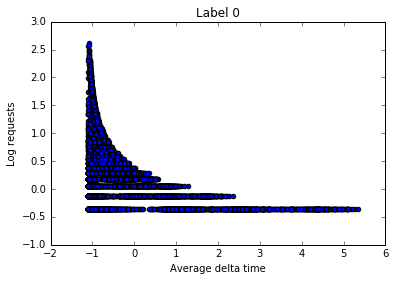

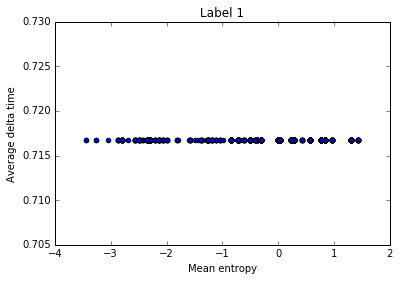

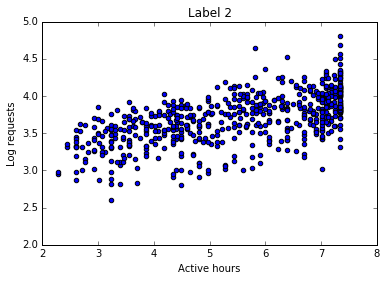

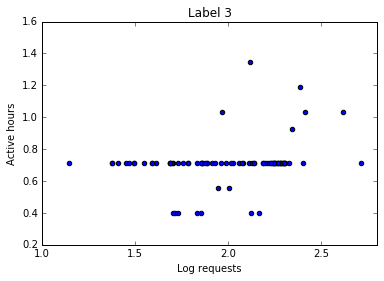

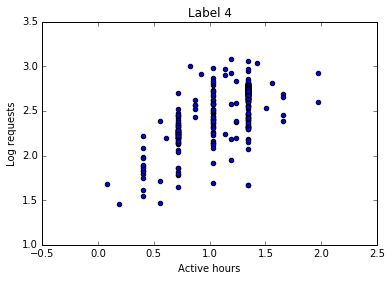

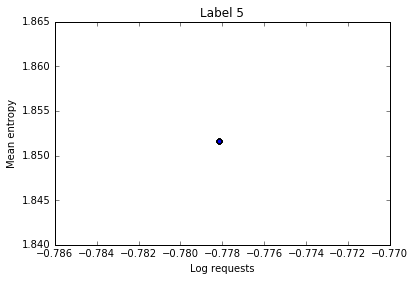

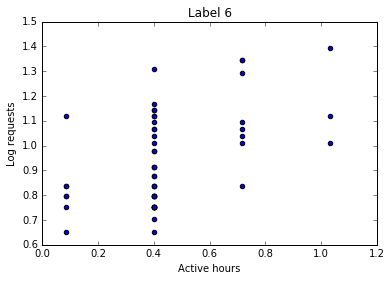

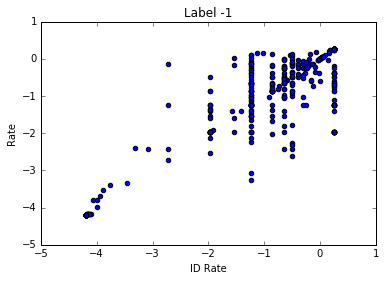

In [100]:
n_features = len(feature_names)

for label in unique_labels:
    var = np.var(cluster_ips_data_scaled[label],axis=0)
    
    res = sorted(zip(var,xrange(0,len(feature_names))),key=lambda x: x[0],reverse=True)[:2]
    
    num1 = res[0][1]
    num2 = res[1][1]
    
    fig, ax = pl.subplots()
    pl.scatter(np.array(cluster_ips_data_scaled[label])[:,num1],
               np.array(cluster_ips_data_scaled[label])[:,num2])
    
    ax.set_title('Label %s'%(label))
    pl.xlabel(feature_names_e[num1])
    pl.ylabel(feature_names_e[num2])
    pl.show()

### Для лучшего понимания взаимного расположения кластеров, визуализируем данные с помощью алгоритма TSNE

In [ ]:
tsne = TSNE(n_components=2,perplexity=50)
transformed_data = tsne.fit_transform(data_set)

In [ ]:
pl.scatter(np.array(transformed_data)[:,0],np.array(transformed_data)[:,1],c=db_scan.labels_,alpha=1)
pl.show()

### Выведем общую информацию о полученных кластерах

In [101]:
n_features = len(feature_names)

for label in unique_labels:
    print "Метка: %d"%(label)
    print "Процент от общего числа данных: %f"%(float(len(cluster_ips[label]))/len(ip_data))
    print "Процент всех запросов по авторизациям: %f"%(1.0*sum([len(ip_records[ip]) for ip in cluster_ips[label]])/len(auth_data)) 
        
    print "Средние занчение параметров по классу:"
    mean_values = np.mean(np.array(cluster_ips_data[label]),axis=0)
    for i in xrange(0,n_features):
        print "%s : %f"%(feature_names[i],mean_values[i])
    print "\n"
    

Метка: 0
Процент от общего числа данных: 0.569820
Процент всех запросов по авторизациям: 0.069097
Средние занчение параметров по классу:
Усредненная энтропия номеров : 1.691599
Рейт : 0.998897
Логарифм общего числа запросов : 1.594650
Рейт по аккаунтам : 0.999568
Среднее время между запросами : 36464.472772
Количество активных часов : 0.166253


Метка: 1
Процент от общего числа данных: 0.356077
Процент всех запросов по авторизациям: 0.004508
Средние занчение параметров по классу:
Усредненная энтропия номеров : 1.777224
Рейт : 1.000000
Логарифм общего числа запросов : 0.000000
Рейт по аккаунтам : 1.000000
Среднее время между запросами : 86400.000000
Количество активных часов : 0.000000


Метка: 2
Процент от общего числа данных: 0.026310
Процент всех запросов по авторизациям: 0.699563
Средние занчение параметров по классу:
Усредненная энтропия номеров : 0.649478
Рейт : 0.000324
Логарифм общего числа запросов : 7.495381
Рейт по аккаунтам : 0.000580
Среднее время между запросами : 161.8131

### Более подробный анализ:
Исходя из предыдущих результатов, наибольший интерес представляет метка #2, <br>
У неё низкий рейт и очень большой процент всех запросов по авторизациям <br>
Хотя метки 3, 4 и 6 тоже являются подозрительными, здесь я их рассматривать не буду,<br>
все действия будут точно такими же, как и для метки 2

In [102]:
bruter_ips = cluster_ips[2]
n_bruters = len(bruter_ips)

In [103]:
n_samles_to_analys = 5
max_values = 20

indexes = [random.randint(0,n_bruters) for i in xrange(0,n_samles_to_analys)]
for i in indexes:
    ip = bruter_ips[i]
    count = max_values
    print "IP: %s"%(ip)
    print "ID \tSUCCESSES\tFAILS"
    for user_id in ip_ids[ip]:
        print "%s  \t%d\t%d\t"%(str(user_id),
                                ip_ids[ip][user_id][0],
                                ip_ids[ip][user_id][1])
        count -= 1
        if count == 0:
            break
            
    print "\n"
    

IP: 41.91.84.15
ID 	SUCCESSES	FAILS
9999922  	0	1	
117771  	0	1	
6666556  	0	1	
9999929  	0	1	
889889  	0	1	
634777  	0	8	
2121221  	0	1	
5558558  	0	1	
3335355  	0	1	
220000  	0	1	
9595955  	0	1	
7447747  	0	1	
2255522  	0	1	
9555995  	0	1	
9499994  	0	1	
1661611  	0	1	
214777  	0	4	
563999  	0	6	
5858588  	0	1	
919191  	0	1	


IP: 237.164.74.156
ID 	SUCCESSES	FAILS
5559955  	0	4	
9998989  	0	2	
634777  	0	18	
110001  	0	1	
4499994  	0	1	
9999929  	0	1	
888585  	0	1	
131113  	0	1	
131111  	0	1	
6666555  	0	1	
224422  	0	1	
999988  	0	1	
151551  	0	1	
5544445  	0	1	
522555  	0	3	
666646  	0	1	
1122112  	0	1	
666644  	0	1	
244244  	0	1	
4949949  	0	2	


IP: 36.5.185.144
ID 	SUCCESSES	FAILS
9998989  	0	1	
9999922  	0	1	
338333  	0	3	
4499999  	0	1	
6600000  	0	1	
634777  	0	13	
338338  	0	2	
131111  	0	2	
717777  	0	1	
4044404  	0	1	
422242  	0	1	
224424  	0	1	
1188118  	0	1	
224422  	0	1	
1155155  	0	1	
101010  	0	1	
6666006  	0	1	
3336633  	0	2	
3336636  	0	1	
776667  	0	1	


IP: 215.2

### Посмотрим, какие параметры оказались наиболее важными для выявляения брутфорсеров

In [116]:
bruteforce_labels = set([2]) #Метки кластеров, в которые попали брутфорсеры
all_labels = db_scan.labels_
n = len(all_labels)

train_y = []
for i in xrange(0, n):
    if all_labels[i] in bruteforce_labels:
        train_y.append(0.0)
    else:
        train_y.append(1.0)
        
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=8)
rf_clf.fit(data_set,train_y)

feature_importances = sorted(zip(feature_names,rf_clf.feature_importances_),
key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print "%s имеет занчимость в %f процентов" %(feature,100*importance)


Количество активных часов имеет занчимость в 41.477529 процентов
Логарифм общего числа запросов имеет занчимость в 28.455505 процентов
Усредненная энтропия номеров имеет занчимость в 14.175819 процентов
Рейт по аккаунтам имеет занчимость в 8.082593 процентов
Рейт имеет занчимость в 4.864060 процентов
Среднее время между запросами имеет занчимость в 2.944494 процентов


### Конечно, вычислять среднюю энтропию для группы номеров - дело затратное<br>
Посмотрим, можно ли ограничиться только средним временем между запросами, рейту и логарифму от общего числа запросов,
зная распределение брутфорсеров

In [118]:
new_data_set = np.array(data_set)[:,(1,2,3,4)]

In [124]:
rf_clf.fit(new_data_set,train_y)
score = rf_clf.score(new_data_set,train_y)

print "Информации, содержащейся в этих данных хватило, чтобы предсказать брутфорс с точностью %f процентов"%(score*100)

Информации, содержащейся в этих данных хватило, чтобы предсказать брутфорс с точностью 100.000000 процентов


In [127]:
selected_features = [feature_names[i] for i in [1,2,3,4]]
feature_importances = sorted(zip(selected_features,rf_clf.feature_importances_),
key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print "%s имеет занчимость в %f процентов" %(feature,100*importance)

Логарифм общего числа запросов имеет занчимость в 65.285624 процентов
Рейт по аккаунтам имеет занчимость в 16.223738 процентов
Рейт имеет занчимость в 11.113597 процентов
Среднее время между запросами имеет занчимость в 7.377042 процентов


### Что дальше ? На основе этих данных можно выделить id пользователей, аккаунты которых могли сбрутить
Все просто, - надо посмотреть, в какие аккаунты авторизовывались и нормальные пользователи и брутфорсеры